In [117]:
# Run reviews_exploratiion.ipynb first.
import pandas as pd
import json
import ast
import numpy as np
import math
import missingno as msno
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [118]:
# Import data.
games_returns_release_df = pd.read_csv('games_returns_release_date.csv')
games_returns_release_df.head()

,Unnamed: 0,Unnamed: 0_x,igdb_id,first_release_date,name,slug,mature,single_player,multiplayer,igdb_name,...,smb,hml,rmw,cma,rf,benchmark_price,returns,benchmark_returns,excess_return,market_cap
0,0,2,117,2016-12-06,The Last Guardian,the-last-guardian,False,True,False,The Last Guardian,...,-0.09,1.07,-0.27,0.14,0.00,1394.21,-0.007726,0.001761,-0.009487,4.029600e+12
1,1,2,117,2016-12-06,The Last Guardian,the-last-guardian,False,True,False,The Last Guardian,...,-0.09,1.07,-0.27,0.14,0.00,1394.21,-0.007724,0.001761,-0.009486,3.292524e+10
2,3,2506,119386,2020-11-30,Empire of Sin,empire-of-sin,True,True,False,Empire of Sin,...,0.47,-1.31,0.02,-0.63,0.00,575.44,0.034510,-0.002600,0.037110,2.785728e+10
3,4,2506,119386,2020-11-30,Empire of Sin,empire-of-sin,True,True,False,Empire of Sin,...,0.47,-1.31,0.02,-0.63,0.00,575.44,0.084647,-0.002600,0.087247,2.760384e+09
4,10,2514,120175,2020-02-27,One Punch Man: A Hero Nobody Knows,one-punch-man-a-hero-nobody-knows,False,True,False,One Punch Man: A Hero Nobody Knows,...,-0.86,0.56,-0.49,0.33,0.01,1480.58,-0.005932,-0.004549,-0.001383,1.254300e+12


In [119]:
# Check columns for columns that can be dropped.
games_returns_release_df.columns

Index(['Unnamed: 0', 'Unnamed: 0_x', 'igdb_id', 'first_release_date', 'name',
       'slug', 'mature', 'single_player', 'multiplayer', 'igdb_name',
       'opencritic_name', 'opencritic_id', 'dist', 'hasLootBoxes',
       'percentRecommended', 'numReviews', 'numTopCriticReviews',
       'medianScore', 'topCriticScore', 'percentile', 'firstReleaseDate',
       'firstReviewDate', 'latestReviewDate', 'variable', 'igdb_company_id',
       'developer', 'publisher', 'stock_id', 'date', 'Unnamed: 0_y', 'gvkey',
       'iid', 'company_name', 'shares_outstanding', 'trading_volume',
       'closing_price', 'total_return_factor', 'eu', 'jp', 'us', 'mkt-rf',
       'smb', 'hml', 'rmw', 'cma', 'rf', 'benchmark_price', 'returns',
       'benchmark_returns', 'excess_return', 'market_cap'],
      dtype='object')

In [120]:
# Drop unused columns.
games_returns_release_df = games_returns_release_df.drop([
    'Unnamed: 0',
    'Unnamed: 0_x',
    'slug',
    'Unnamed: 0_y',
    'gvkey',
    'shares_outstanding',
    'total_return_factor',
    'variable',
    'igdb_name',
    'opencritic_id',
    'first_release_date',
    'benchmark_returns'
    ], axis=1)

games_returns_release_df.head()

,igdb_id,name,mature,single_player,multiplayer,opencritic_name,dist,hasLootBoxes,percentRecommended,numReviews,...,mkt-rf,smb,hml,rmw,cma,rf,benchmark_price,returns,excess_return,market_cap
0,117,The Last Guardian,False,True,False,The Last Guardian,0.0,False,70.491803,128.0,...,0.49,-0.09,1.07,-0.27,0.14,0.00,1394.21,-0.007726,-0.009487,4.029600e+12
1,117,The Last Guardian,False,True,False,The Last Guardian,0.0,False,70.491803,128.0,...,0.49,-0.09,1.07,-0.27,0.14,0.00,1394.21,-0.007724,-0.009486,3.292524e+10
2,119386,Empire of Sin,True,True,False,Empire of Sin,0.0,False,27.118644,60.0,...,-1.10,0.47,-1.31,0.02,-0.63,0.00,575.44,0.034510,0.037110,2.785728e+10
3,119386,Empire of Sin,True,True,False,Empire of Sin,0.0,False,27.118644,60.0,...,-1.10,0.47,-1.31,0.02,-0.63,0.00,575.44,0.084647,0.087247,2.760384e+09
4,120175,One Punch Man: A Hero Nobody Knows,False,True,False,One-Punch Man: A Hero Nobody Knows,0.0,False,17.105263,76.0,...,-1.63,-0.86,0.56,-0.49,0.33,0.01,1480.58,-0.005932,-0.001383,1.254300e+12


In [121]:
games_returns_release_df[['mature',
                          'single_player', 
                          'multiplayer', 
                          'hasLootBoxes', 
                          'developer',
                          'publisher',
                          'eu',
                          'jp',
                          'us']] = games_returns_release_df[['mature',
                          'single_player', 
                          'multiplayer', 
                          'hasLootBoxes', 
                          'developer',
                          'publisher',
                          'eu',
                          'jp',
                          'us']].astype(int)

In [122]:
# Plot missing data.
%matplotlib inline

msno.matrix(games_returns_release_df)

<Axes: >

Error in callback <function _draw_all_if_interactive at 0x16a4e6840> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 2500x1000 with 2 Axes>

In [ ]:
def run_ols_model(df, dependent_var, independent_vars):
    X = df[independent_vars]
    Y = df[dependent_var]
    
    X = sm.add_constant(X)
    
    model = sm.OLS(Y, X).fit()
    predictions = model.predict(X)
    
    return model.summary()

In [ ]:
games_returns_release_df.columns

Index(['igdb_id', 'name', 'mature', 'single_player', 'multiplayer',
       'opencritic_name', 'dist', 'hasLootBoxes', 'percentRecommended',
       'numReviews', 'numTopCriticReviews', 'medianScore', 'topCriticScore',
       'percentile', 'firstReleaseDate', 'firstReviewDate', 'latestReviewDate',
       'igdb_company_id', 'developer', 'publisher', 'stock_id', 'date', 'iid',
       'company_name', 'trading_volume', 'closing_price', 'eu', 'jp', 'us',
       'mkt-rf', 'smb', 'hml', 'rmw', 'cma', 'rf', 'benchmark_price',
       'returns', 'excess_return', 'market_cap'],
      dtype='object')

In [ ]:
x_df = games_returns_release_df[['mature',
                                'single_player', 
                                'multiplayer', 
                                'hasLootBoxes', 
                                'medianScore',
                                'developer',
                                'publisher',
                                'eu',
                                'jp',
                                'us',
                                'mkt-rf',
                                'smb',
                                'hml',
                                'rmw',
                                'cma',
                                'rf',
                                'market_cap']]
x_df.dtypes

mature             int64
single_player      int64
multiplayer        int64
hasLootBoxes       int64
medianScore      float64
developer          int64
publisher          int64
eu                 int64
jp                 int64
us                 int64
mkt-rf           float64
smb              float64
hml              float64
rmw              float64
cma              float64
rf               float64
market_cap       float64
dtype: object

In [ ]:
results_hic = run_ols_model(games_returns_release_df[(games_returns_release_df['excess_return'] < 3.5) & (games_returns_release_df['numReviews'] > 0)], 'medianScore', ['mature',
                                                   'single_player', 
                                                   'multiplayer', 
                                                   #'hasLootBoxes', 
                                                   'developer',
                                                   'publisher',
                                                   'eu',
                                                   'jp',
                                                   'us',
                                                   'mkt-rf',
                                                   'smb',
                                                   'hml',
                                                   'rmw',
                                                   'cma',
                                                   'rf',
                                                   'market_cap'])
print(results_hic)

                            OLS Regression Results                            
Dep. Variable:            medianScore   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     6.273
Date:                Thu, 01 Jun 2023   Prob (F-statistic):           1.11e-10
Time:                        10:42:29   Log-Likelihood:                -3177.7
No. Observations:                 836   AIC:                             6381.
Df Residuals:                     823   BIC:                             6443.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            36.5012      4.276      8.536

In [ ]:
def subplot_common_y(df, dependent_var, independent_vars, num_columns, y_label, **kwargs):

    titles = kwargs.get('titles', None)
    x_labels = kwargs.get('x_labels', None)
    y = df[dependent_var]
    suptitle = kwargs.get('suptitle', None)
    colours=kwargs.get('colours')

    # Calculate the number of subplots based on how many X values being compared.
    num_subplots = len(independent_vars)

    rows = math.ceil(num_subplots/num_columns)
    cols = num_columns
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize = (9, 9))
    fig.suptitle(suptitle)

    for i, ax in enumerate(fig.axes):
        try:
            x = df[independent_vars[i]]
            if colours != None:
                ax.scatter(x, y, s=20, alpha=0.2, edgecolors="k", c=colours[i])
            else:
                ax.scatter(x, y, s=20, alpha=0.2, edgecolors="k")
            if titles != None:
                ax.set_title(titles[i])
            if x_labels != None:
                ax.set_xlabel(x_labels[i])
            ax.set_ylabel(y_label)
            b, a = np.polyfit(x, y, deg=1)

            # Create sequence of 100 numbers from 0 to 100 
            xseq = np.linspace(0, max(x), num=100)

            # Plot regression line
            ax.plot(xseq, a + b * xseq, color="r", lw=1)

        except KeyError:
            print('Too many indices.')
            continue


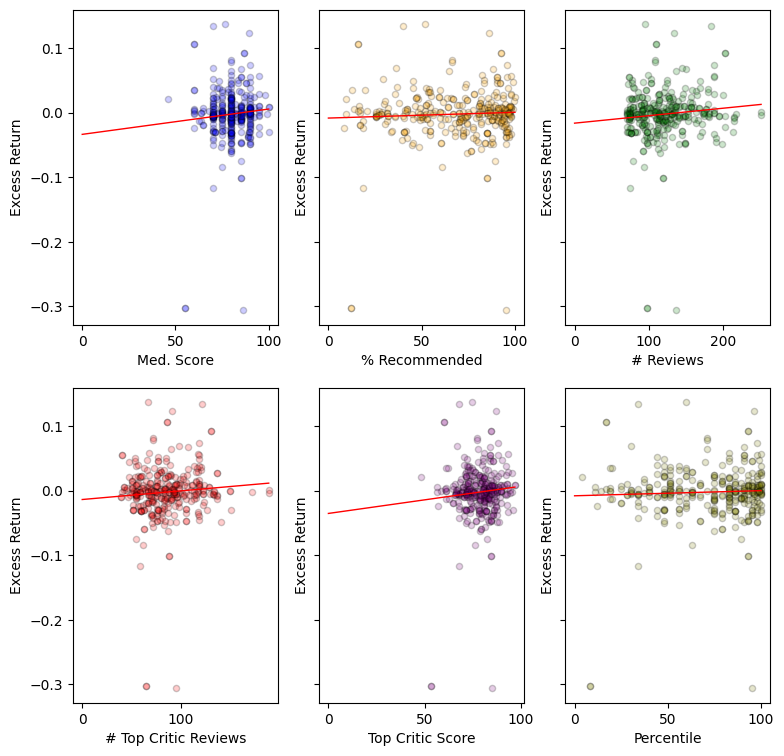

In [ ]:
subplot_common_y(
    df=games_returns_release_df[(games_returns_release_df['excess_return'] < 3.5) & (games_returns_release_df['numReviews'] > 70)],
    dependent_var='excess_return',
    independent_vars=[
        'medianScore',
        'percentRecommended',
        'numReviews',
        'numTopCriticReviews',
        'topCriticScore',
        'percentile'
        ],
    num_columns=3,
    x_labels =[
        'Med. Score',
        '% Recommended',
        '# Reviews',
        '# Top Critic Reviews',
        'Top Critic Score',
        'Percentile'
        ],
    y_label='Excess Return',
    colours=['blue', 'orange', 'green', 'red', 'purple', 'olive']
  )

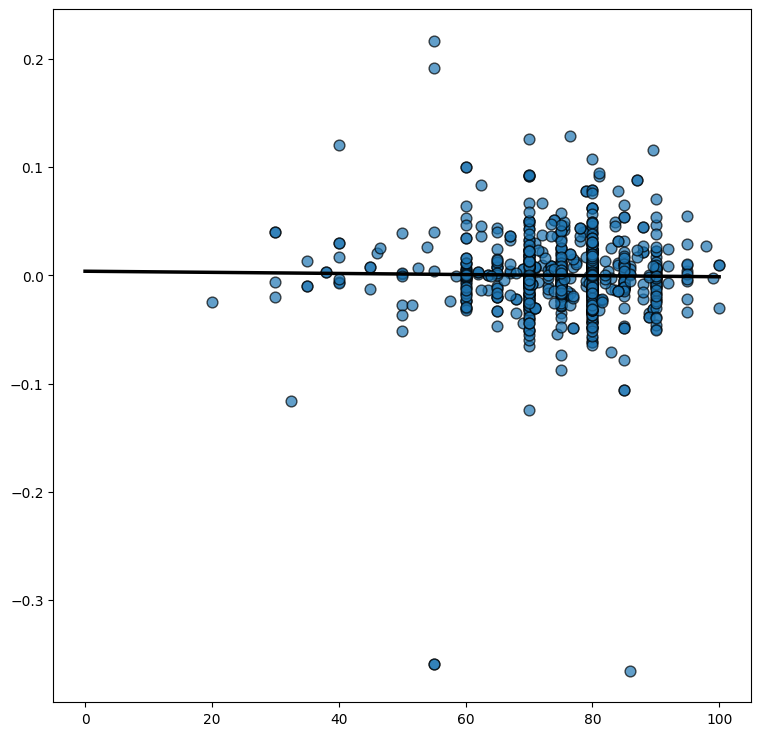

In [ ]:
# Generate data
data_df = games_returns_release_df[(games_returns_release_df['excess_return'] < 3.5) & (games_returns_release_df['numReviews'] > 10)]
x = data_df['medianScore']
y = np.log(data_df['excess_return'] + 1)

# Initialize layout
fig, ax = plt.subplots(figsize = (9, 9))

# Add scatterplot
ax.scatter(x, y, s=60, alpha=0.7, edgecolors="k")

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
b, a = np.polyfit(x, y, deg=1)

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, max(x), num=100)

# Plot regression line
ax.plot(xseq, a + b * xseq, color="k", lw=2.5)

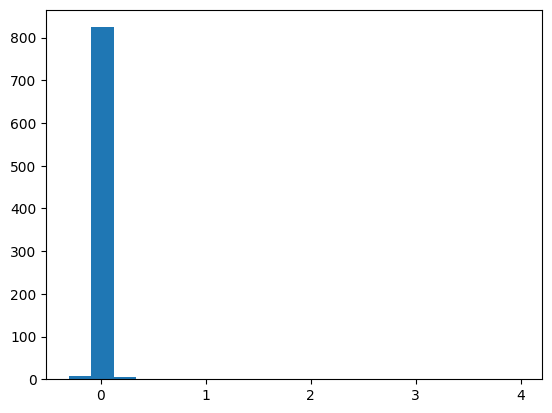

In [ ]:
plt.hist(games_returns_release_df['excess_return'], bins = 20)
plt.show() 

Text(0.5, 0, 'Excess Returns')

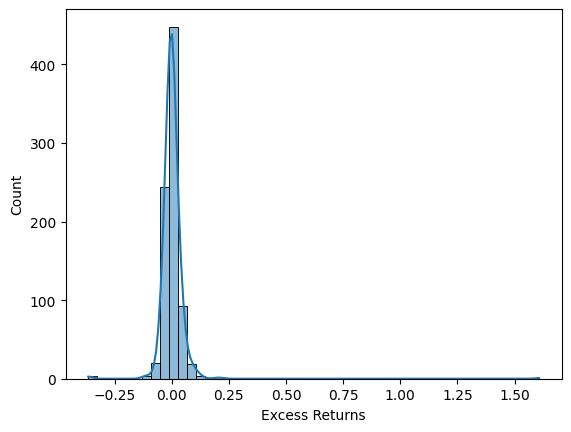

In [ ]:
# Density Plot
sns.histplot(np.log(games_returns_release_df['excess_return'] + 1), kde=True, bins=50, line_kws={'color':'black'}).set_xlabel('Excess Returns')

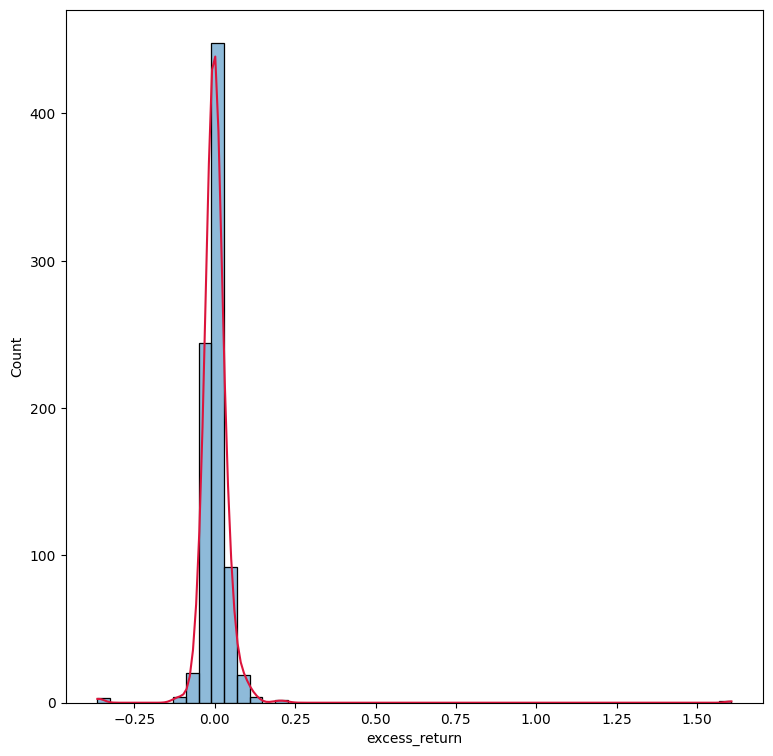

In [ ]:
fig, ax = plt.subplots(figsize = (9, 9))
ax = sns.histplot(np.log(games_returns_release_df['excess_return'] + 1), kde=True, bins=50)
ax.lines[0].set_color('crimson')

In [ ]:
games_returns_release_df[['mature',
                          'returns',
                                      'single_player', 
                                      'multiplayer', 
                                      #'hasLootBoxes', 
                                      'medianScore',
                                      'developer',
                                      'publisher',
                                      'eu',
                                      'jp',
                                      'us',
                                      'mkt-rf',
                                      'smb',
                                      'hml',
                                      'rmw',
                                      'cma',
                                      'rf',
                                      'market_cap',
                                      'excess_return']].corr()

,mature,returns,single_player,multiplayer,medianScore,developer,publisher,eu,jp,us,mkt-rf,smb,hml,rmw,cma,rf,market_cap,excess_return
mature,1.000000,-0.007975,0.050576,-0.044983,-0.047665,-0.045274,0.045274,0.156480,-0.174340,0.047693,-0.100150,0.000405,-0.041480,0.016612,-0.019132,0.009165,-0.109881,-0.003379
returns,-0.007975,1.000000,-0.150443,0.155171,0.041591,-0.013152,0.013152,-0.013536,0.020912,-0.015203,-0.036890,0.032762,-0.018538,0.022083,0.014138,-0.004201,-0.020582,0.994377
single_player,0.050576,-0.150443,1.000000,-0.969800,0.119142,0.039579,-0.039579,0.115272,-0.042017,-0.129014,-0.004893,-0.076142,0.003525,-0.109534,-0.019210,0.022888,-0.088996,-0.140320
multiplayer,-0.044983,0.155171,-0.969800,1.000000,-0.116404,-0.035469,0.035469,-0.110278,0.033533,0.136082,0.026251,0.089788,-0.011411,0.118732,0.011350,-0.036150,0.081172,0.144482
medianScore,-0.047665,0.041591,0.119142,-0.116404,1.000000,0.008428,-0.008428,-0.135554,0.089509,0.075541,-0.007686,-0.037809,0.002596,0.090159,-0.016026,-0.014082,0.151301,0.041717
developer,-0.045274,-0.013152,0.039579,-0.035469,0.008428,1.000000,-1.000000,-0.145423,0.200568,-0.117548,0.041604,0.021014,0.017632,-0.030396,0.026822,-0.030908,-0.079737,-0.016216
publisher,0.045274,0.013152,-0.039579,0.035469,-0.008428,-1.000000,1.000000,0.145423,-0.200568,0.117548,-0.041604,-0.021014,-0.017632,0.030396,-0.026822,0.030908,0.079737,0.016216
eu,0.156480,-0.013536,0.115272,-0.110278,-0.135554,-0.145423,0.145423,1.000000,-0.855833,-0.185889,0.017176,-0.052370,-0.009046,0.008558,-0.015355,0.096113,-0.331600,-0.016162
jp,-0.174340,0.020912,-0.042017,0.033533,0.089509,0.200568,-0.200568,-0.855833,1.000000,-0.349147,-0.020298,0.032659,-0.000596,-0.038023,0.008298,-0.083306,0.353032,0.024012
us,0.047693,-0.015203,-0.129014,0.136082,0.075541,-0.117548,0.117548,-0.185889,-0.349147,1.000000,0.007442,0.032836,0.017518,0.056724,0.012054,-0.015873,-0.069884,-0.016334


In [ ]:
def subplot_hist(df, variables, num_columns, x_labels, **kwargs):

    titles = kwargs.get('titles', None)
    suptitle = kwargs.get('suptitle', None)
    colours = kwargs.get('colours', None)

    # Calculate the number of subplots based on how many X values being compared.
    num_subplots = len(variables)

    rows = math.ceil(num_subplots/num_columns)
    cols = num_columns
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize = (9, 9))
    fig.suptitle(suptitle)

    for i, ax in enumerate(fig.axes):
        try:
            y = df[variables[i]]
            if colours != None:
                sns.histplot(y, kde=True, ax=ax, color=colours[i])
            else:
                sns.histplot(y, kde=True, ax=ax)
            if titles != None:
                ax.set_title(titles[i])
            if x_labels != None:
                ax.set_xlabel(x_labels[i])

        except KeyError:
            print('Too many indices.')
            continue

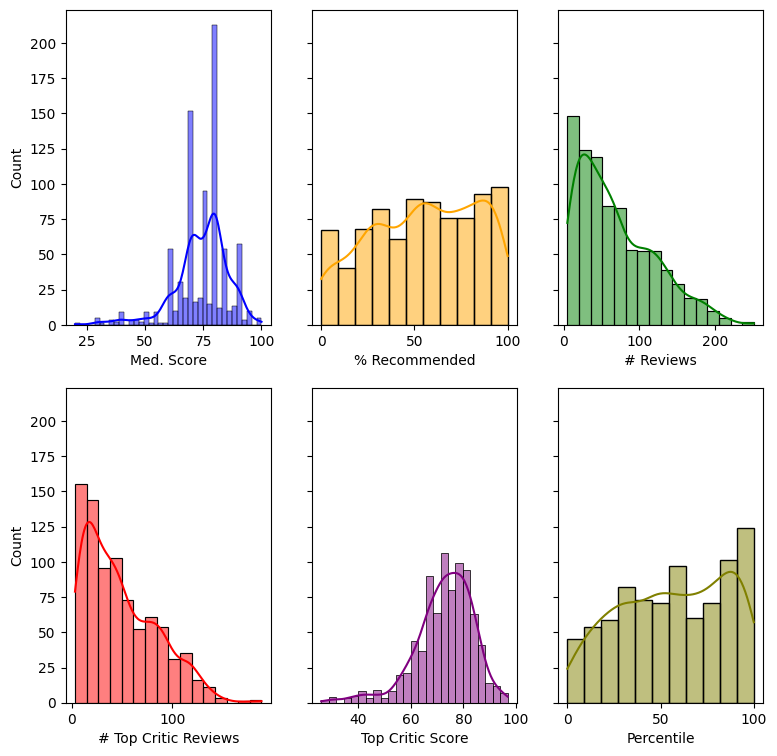

In [ ]:
subplot_hist(
    df=games_returns_release_df,
    variables=[
        'medianScore',
        'percentRecommended',
        'numReviews',
        'numTopCriticReviews',
        'topCriticScore',
        'percentile'
        ],
    num_columns=3,
    x_labels=[
        'Med. Score',
        '% Recommended',
        '# Reviews',
        '# Top Critic Reviews',
        'Top Critic Score',
        'Percentile'
        ],
    colours=['blue', 'orange', 'green', 'red', 'purple', 'olive']
    )